# Prepare Environment

In [1]:
import os
import numpy as np
import glob
import shutil
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as transforms #
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import OxfordIIITPet
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {DEVICE}")

BATCH_SIZE = 16
NUM_EPOCHS = 2
LEARNING_RATE = 1e-4

IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

validation_split = .2

device: cuda


# Download Dataset

In [3]:
# Create directory for train and valid sets
data_dir = './oxford-pet-dataset'
for s in ['train', 'valid']:
    for t in ['img', 'mask']:
        new_dir = f'./oxford-pet-dataset/{s}_{t}'
        if not os.path.isdir(new_dir):
            os.makedirs(new_dir)
if not os.path.isdir('./saved_imgs'):
    os.makedirs('./saved_imgs')

In [4]:
# Download dataset
OxfordIIITPet(
    root='./',
    split='trainval',
    target_types='segmentation',
    download=True)

oxford_img_dir = '/content/oxford-iiit-pet/images'
oxford_mask_dir = '/content/oxford-iiit-pet/annotations/trimaps'

100%|██████████| 791918971/791918971 [00:57<00:00, 13776742.73it/s]


Extracting oxford-iiit-pet/images.tar.gz to oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 7141890.06it/s] 


Extracting oxford-iiit-pet/annotations.tar.gz to oxford-iiit-pet


In [5]:
# Split
img_paths = glob.glob(
    os.path.join(oxford_img_dir,'*.jpg'))
dataset_size = len(img_paths)
split = int(np.floor(validation_split * dataset_size))
np.random.shuffle(img_paths)
train_paths, val_paths = img_paths[split:], img_paths[:split]

In [6]:
# Copy files
for split_name, paths in [('train', train_paths), ('valid', val_paths)]:
    for src_img in paths:
        fn = os.path.basename(src_img)
        mask_fn = fn.replace('.jpg', '.png')
        src_mask = os.path.join(oxford_mask_dir, mask_fn)
        dst_img = os.path.join(data_dir, f'{split_name}_img', fn)
        dst_mask = os.path.join(data_dir, f'{split_name}_mask', mask_fn)
        shutil.copy(src_img, dst_img)
        shutil.copy(src_mask, dst_mask)

# Prepare Dataset

In [7]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", ".png"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.uint8)
        mask = mask - 1  # Make it start from 0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [8]:
# Transformation for data augmentation
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

In [9]:
# DataSet and DataLoader

# TODO: Create dataloaders for training and validation sets
train_ds = CustomDataset("/content/oxford-pet-dataset/train_img","/content/oxford-pet-dataset/train_mask" ,train_transform);
valid_ds = CustomDataset("/content/oxford-pet-dataset/valid_img" ,"/content/oxford-pet-dataset/valid_mask" ,val_transform);
train_loader = DataLoader(train_ds, batch_size= BATCH_SIZE, shuffle=True)# YOUR CODE HERE
val_loader = DataLoader(valid_ds, batch_size= BATCH_SIZE, shuffle=False)

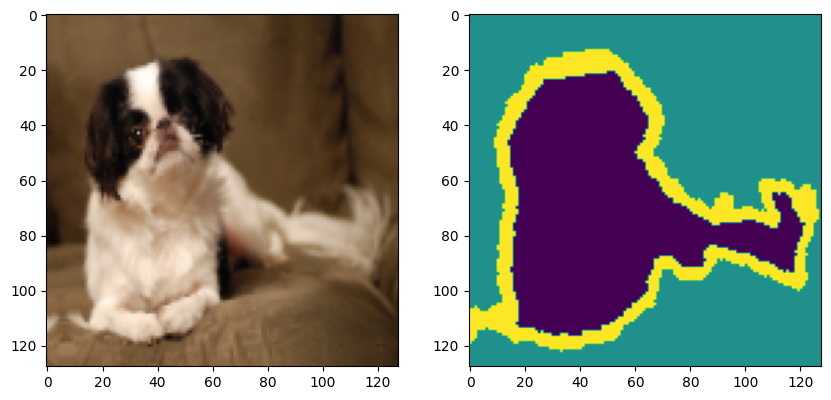

In [10]:
# Plot an example (repeat should give a different randomess)
img, mask = train_ds[42]
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(img.numpy().transpose((1,2,0)))
axs[1].imshow(mask.numpy())
plt.show()
plt.close('all')

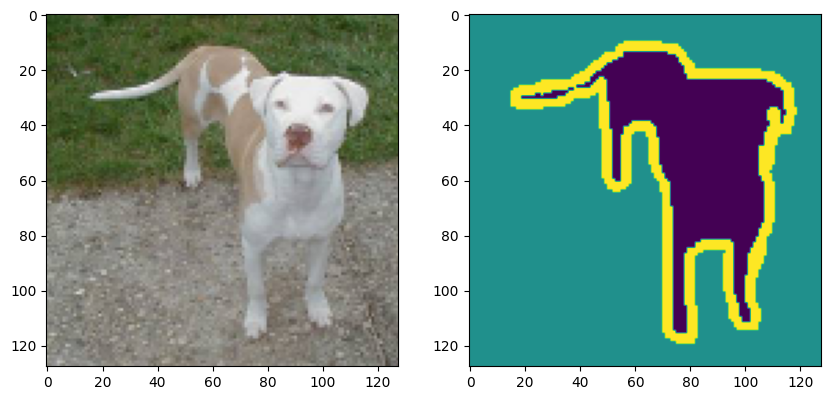

In [11]:
# Plot an example (repeat should yield the same output)
img, mask = valid_ds[42]
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(img.numpy().transpose((1,2,0)))
axs[1].imshow(mask.numpy())
plt.show()
plt.close('all')

# Model

![u-net](https://raw.githubusercontent.com/zhixuhao/unet/master/img/u-net-architecture.png)

In [12]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, channels=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for chs in channels:
            self.downs.append(DoubleConv(in_channels, chs))
            in_channels = chs

        # Up part of UNET
        for chs in reversed(channels):
            self.ups.append(
                nn.ConvTranspose2d(
                    chs*2, chs, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(chs*2, chs))

        self.bottleneck = DoubleConv(channels[-1], channels[-1]*2)
        self.final_conv = nn.Conv2d(channels[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [13]:
# TODO: Create a UNET model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = UNET(channels=[64, 128, 256, 512, 1024, 2048])
model = UNET(3,3)
#model = UNET([3, 64, 1, 1])
model.to(device)

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

# Training

In [14]:
# One training epoch
def train_fn(loader, model, optimizer, loss_fn, scaler):
    model.train()
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.long().to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [15]:
# Utility functions
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )

In [16]:
# Check the performance before training
check_accuracy(val_loader, model, device=DEVICE)

Got 2920310/24215552 with acc 12.06


In [17]:
# Training config
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

# TODO: Create an optimizer

#optimizer = optim.SGD(model.parameters(), lr=1e-4)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

100%|██████████| 370/370 [01:16<00:00,  4.87it/s, loss=1.07]


=> Saving checkpoint
Got 12140002/24215552 with acc 50.13


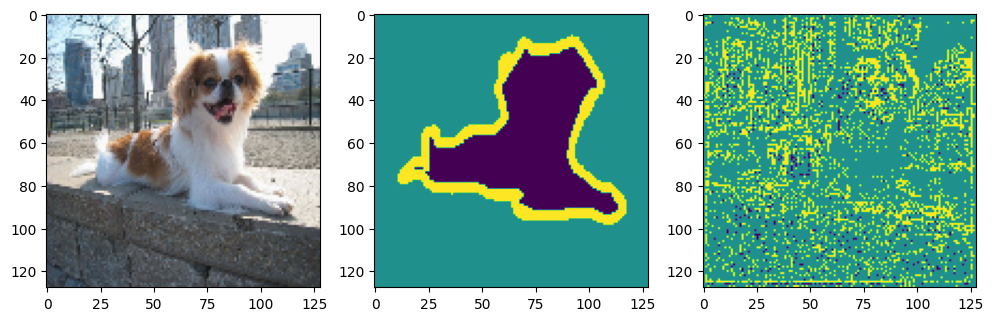

100%|██████████| 370/370 [01:17<00:00,  4.78it/s, loss=1]


=> Saving checkpoint
Got 12893520/24215552 with acc 53.24


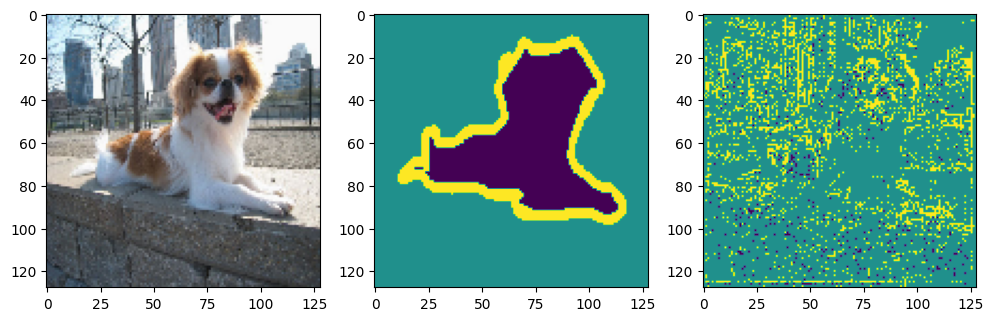

In [18]:
# Load the pre-trained model (if any)
if os.path.isfile("my_checkpoint.pth.tar"):
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

# Start training
for epoch in range(NUM_EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn, scaler)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)

    # check accuracy
    check_accuracy(val_loader, model, device=DEVICE)

    # test on validation set
    model.eval()
    imgs, masks = next(iter(val_loader))
    imgs = imgs.to(device=DEVICE)
    logits = model(imgs)
    pred_masks = torch.argmax(logits, dim=1)
    i = 0
    fig, axs = plt.subplots(1, 3, figsize=(12,6))
    axs[0].imshow(imgs[i].cpu().numpy().transpose(1,2,0))
    axs[1].imshow(masks[i].cpu().numpy())
    axs[2].imshow(pred_masks[i].cpu().numpy())
    plt.show()
    plt.close('all')

# Prediction

In [19]:
from google.colab import files
uploaded = files.upload()

Saving cutest-dog-breeds.png to cutest-dog-breeds.png


In [31]:
# TODO: Create a UNET model

loaded_model = UNET(3,3).to(DEVICE)
# TODO: Load the trained model
# YOUR CODE HERE
model = load_checkpoint(torch.load("my_checkpoint.pth.tar"), loaded_model)


=> Loading checkpoint


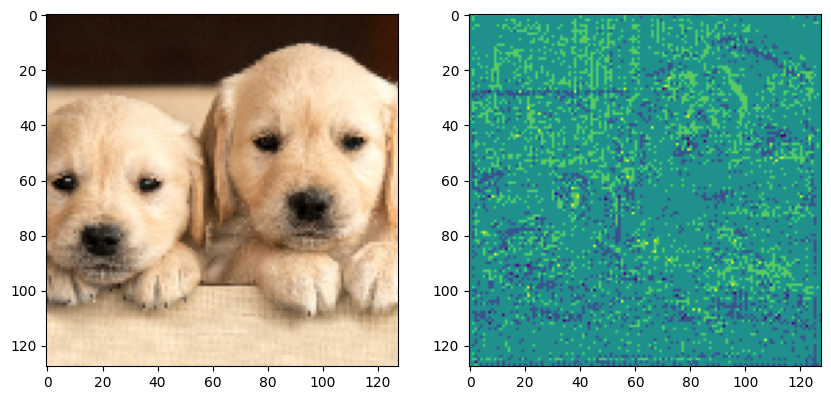

In [32]:
for img_path in uploaded:
    # Step 1: Read an uploaded image
    
    image = np.array(Image.open(img_path).convert("RGB")) # YOUR CODE HERE
     
    # Step 2: Apply transformation
    #img = np.array(image)
    transformed = val_transform(image=image) # YOUR CODE HERE
    img = transformed['image']
    #img = val_transform(image=image)['image']
    # Step 3: Add batch dimension
    img = img.unsqueeze(0) # YOUR CODE HERE

    # Step 4: Make predictions (will get the logits)
    img = img.to(DEVICE)
    logits = loaded_model(img) # YOUR CODE HERE

    # Step 5: Convert the logits to predicted mask
    pred_mask = pred_masks - torch.argmax(logits, dim=1) # YOUR CODE HERE

    # Plot the predicted mask
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    #axs[0].imshow(img[0].detach().cpu().numpy().transpose(1, 1200, 1200))
    #axs[1].imshow(pred_mask[0].detach().cpu().numpy())
    axs[0].imshow(img[0].cpu().numpy().transpose(1,2,0))
    axs[1].imshow(pred_mask[0].cpu().numpy())
    plt.show()
    plt.close('all')